### <b>Table of Content</b>

0. Import functions

1. Load data

2. 

2. Create Bollinger Bands

### <b>0. Import functions</b>

In [1]:
import sys
import os
from pathlib import Path

from utils.load import load_dataframes
from utils.transform import convert_vol_to_float, add_moving_average, add_seasonal_components, add_datetime_features,\
                            normalize_scale
from utils.plot import plot_histograms, plot_heatmap
from utils.stats_functions import run_chi_tests

import warnings
warnings.simplefilter('ignore', UserWarning)

### <b>1. Load data</b>

In [2]:
# Assign details of the source file in G Drive to local variables.
base_url = 'https://drive.google.com/file/d/'
file_id = '1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk'
file_url = f'{base_url}{file_id}'
file_name = '2020Q1Q2Q3Q4-2021Q1.xlsx'

# Assign details of local directories to local variables.
root_dir = sys.path[0]
download_dir = Path(root_dir) / 'data'
file_path = download_dir / file_name

# Download the file if it's not found in the file path.
if os.path.exists(file_path):
    print(f'File {file_name} already exists in {download_dir}.')
else:
    if os.getcwd() != download_dir:
        os.chdir(download_dir)
    print(f'File {file_name} is not found in {download_dir}.')
    !gdown 1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk

# Move back to the root directory.
if os.getcwd() != root_dir:
    os.chdir(root_dir)

File 2020Q1Q2Q3Q4-2021Q1.xlsx already exists in d:\OneDrive\GitHub\Apziva\FAxAtx2ZjFTGstEu\data.


In [16]:
full_sheet_names = [
    'Russia - Sberbank Rossii PAO (SBER)',
    'Turkey - Koc Holding AS (KCHOL)',
    'Egypt - Medinet Nasr Housing (MNHD)',
    'Brazil - Minerva SA/Brazil (BEEF3)',
    'Argentina - Pampa Energia SA (PAMP)',
    'Colombia - Cementos Argos SA (CCB)',
    'South Africa - Impala Platinum Holdings Ltd (IMPJ)',
    'South Korea - Dongkuk Steel Mill Co Ltd (001230)'
]
data_dfs = load_dataframes(file_path, full_sheet_names)

8 DataFrames loaded with the following sheet names:

Russia - Sberbank Rossii PAO (SBER)
Turkey - Koc Holding AS (KCHOL)
Egypt - Medinet Nasr Housing (MNHD)
Brazil - Minerva SA/Brazil (BEEF3)
Argentina - Pampa Energia SA (PAMP)
Colombia - Cementos Argos SA (CCB)
South Africa - Impala Platinum Holdings Ltd (IMPJ)
South Korea - Dongkuk Steel Mill Co Ltd (001230)


### <b>2. EDA and evaluate feature importance?</b>

#### Have a look at the first data frame.

In [21]:
first_df = data_dfs[full_sheet_names[0]]
print('Basic info of the first DateFrame:\n')
print(first_df.info())
print('\n')
print('Tail of the first DataFrame:\n')
print(first_df.tail())

Basic info of the first DateFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      311 non-null    datetime64[ns]
 1   Price     311 non-null    float64       
 2   Open      311 non-null    float64       
 3   High      311 non-null    float64       
 4   Low       311 non-null    float64       
 5   Vol.      311 non-null    object        
 6   Change %  311 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.1+ KB
None


Tail of the first DataFrame:

          Date   Price    Open    High     Low    Vol.  Change %
306 2020-01-10  258.19  257.86  259.25  256.88  18.85M    0.0008
307 2020-01-09  257.99  259.40  261.76  257.01  38.33M   -0.0045
308 2020-01-08  259.15  253.57  259.15  253.03  40.82M    0.0207
309 2020-01-06  253.90  254.75  254.84  251.40  22.35M   -0.0043
310 2020-01-

Since we have time-series data, the 'Date' column will be set to index.

The dtype of the 'Vol.' column is object, which needs to be converted to either integer or float so that the values are 'machine-readable'.

The 'Price' column will be the target to be predicted, which is the closing price for each trading date.

In [22]:
df = first_df.set_index('Date').sort_index()
df['Vol.'] = df['Vol.'].apply(convert_vol_to_float)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-01-08,259.15,253.57,259.15,253.03,40820000.0,0.0207
2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.0045
2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.0008
...,...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,35220000.0,0.0030
2021-03-26,291.22,288.63,292.75,288.32,56070000.0,0.0159
2021-03-29,293.30,289.72,294.09,289.26,43680000.0,0.0071


#### Plot histograms and box plots.

Distribution of target "Price" and dependent variables:


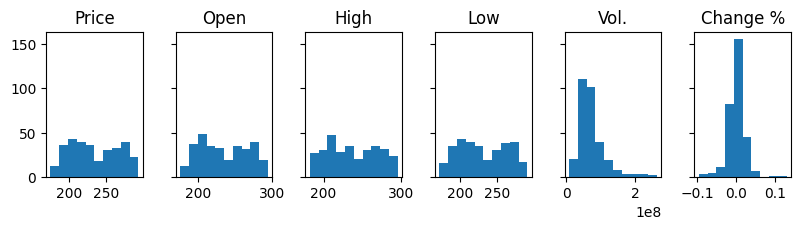

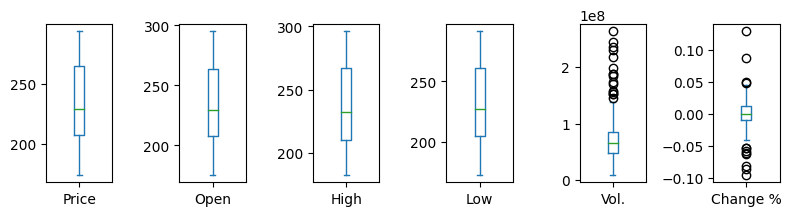

In [23]:
plot_histograms(data=df,
                target='Price', target_figsize=(2,2),
                dependent_layout=(2,9), dependent_figsize=(12, 4),
                include_boxplots=True)

The 'Vol.' column is right-skewed and the 'Change %' column is roughly normally distributed.

#### Plot a correlation heatmap.

,Price,Open,High,Low,Vol.,Change %
Price,1.000000,0.992246,0.996541,0.995765,-0.245279,0.089939
Open,0.992246,1.000000,0.996392,0.996370,-0.262197,-0.014046
High,0.996541,0.996392,1.000000,0.994497,-0.215092,0.034574
Low,0.995765,0.996370,0.994497,1.000000,-0.291138,0.037396
Vol.,-0.245279,-0.262197,-0.215092,-0.291138,1.000000,0.044594
Change %,0.089939,-0.014046,0.034574,0.037396,0.044594,1.000000


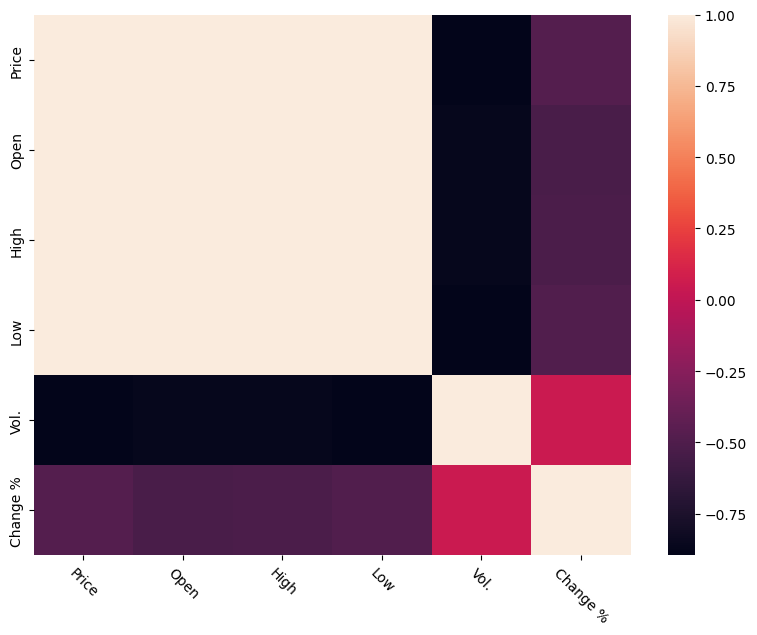

In [27]:
plot_heatmap(df.corr(), figsize=(8, 6), rotate_xticks=-45)
df.corr()

The correlation of the 'Vol.' column and the target (i.e. 'Price') is very low, and the correlation between the 'Change %' and 'Price' columns is also pretty low, thus these two columns would not be useful in training a prediction model.

#### Plot seasonal components

Plot seasonal componets of train_df_1:


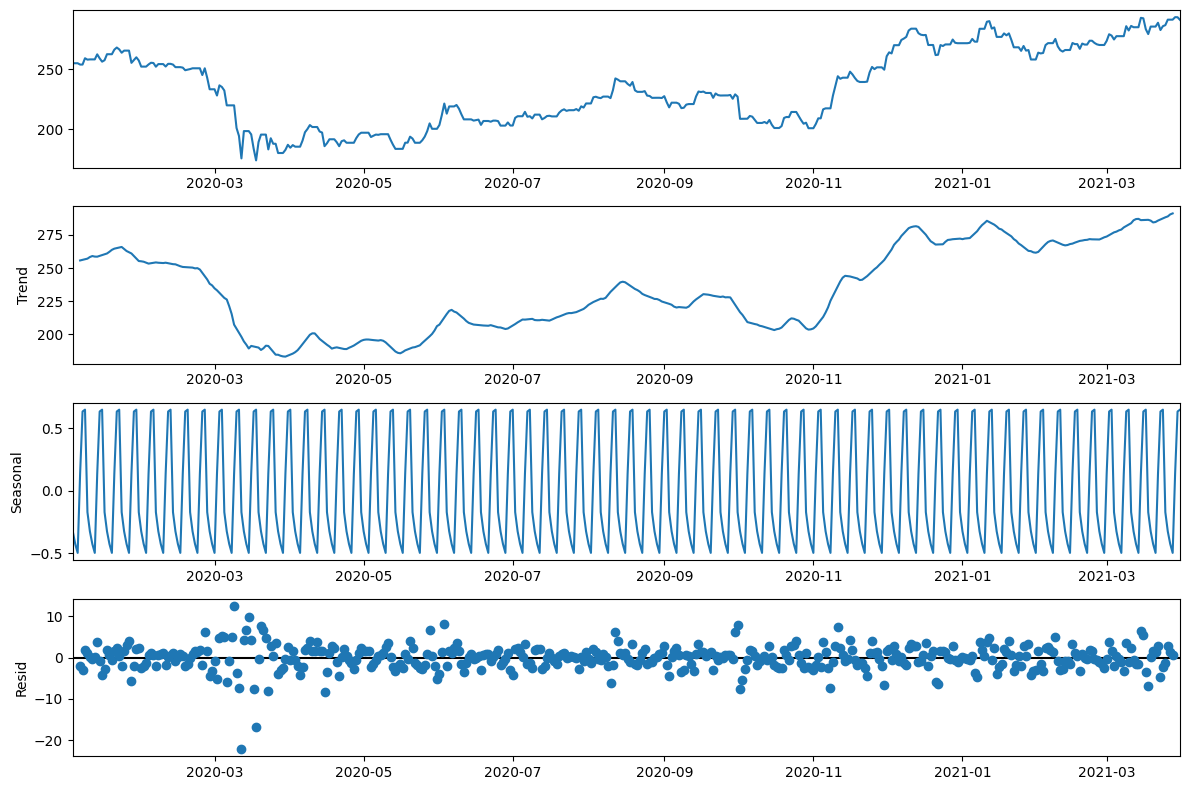

In [36]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

print('Plot seasonal componets of df:')
train_df_1 = add_seasonal_components(df=df, frequency='D', column='Price', add_to_df=False, plot=True)

#### Plot auto correlation and partial autocorrelation.

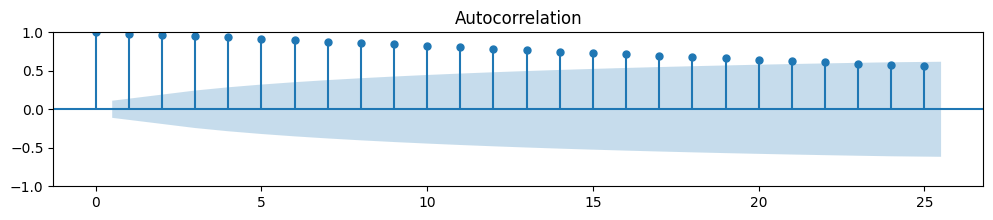

In [38]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 2

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Price']);

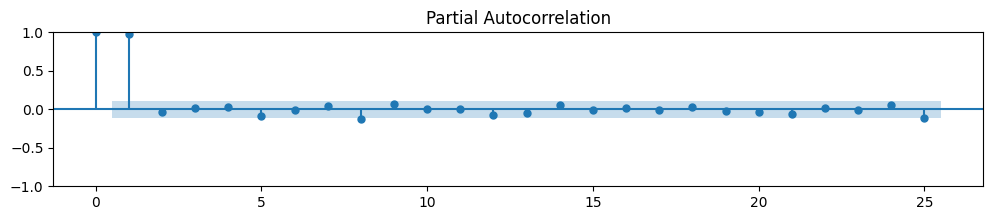

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Price'], method='ywm');

#### Run chi tests

In [4]:
results_dfs = run_chi_tests(normalized_train_df_1, target='Close', significance_level=0.05,
                            plot_title=None, plot_title_y=None,
                            plot_row=3, plot_col=6, figsize=None, plot=False,
                            rotate_x_label_col=[], rotate_angle=None,
                            h_pad=3, print_result_df=False,
                            independence_test=True,
                            goodness_of_fit_test=False)

print('''
If the null hypothesis is not rejected at the significance level of 0.05,
the Variable and the target (i.e. Close) are independent of each other.
''')
results_dfs[0]

NameError: name 'plt' is not defined

### <b>3. feature selection?</b>

If you are training a regression model, get trading decisions based on the bollinger bands created based on the actual price against the predicted price.

If you want to use the price 7 days ago, use 7-day rolling average instead, rather than the actual price 7 days ago.

possible features to use:
- on average has the price gone up or donw in the last week?
- what is the change over the last 2 days (prices on day-1 vs. day-2), last 3 days, 4 days, or a week?
- this is to get model learns/captures the price movement in the recent past.

Forget about the balance when trading and simply take trading action based on the predicted decision even if the balance would go negative. If you care too much about having fewer 'hold' decisions, you will essentially optimize for trading everyday (i.e. without hold decisions) rather than optimizing for making more profit.

# Don't think too much and keep it simple. There's no right answer as you can define the solution in so many different ways.

* if the predicted price is lower than the lower bound—> buy
* if the predicted price is higher than the upper bound—> sell
* if within the Bollinger band, hold.

adjust parameters of the bollinger bands so that there will be as few Hold decision as possible.

After labeling, add_data_from_past and use them as training features to train a classification model.

1. 'Vol.' and 'Change %' are not relevant based on correlation coefficeints with the target column 'Price', hence drop them.
2. Only the previous date's price is highly correlated with today's price based on auto correlation, thus don't look too further in the past.

In [143]:
df = data_dfs[full_sheet_names[0]].set_index('Date').sort_index().drop(['Vol.', 'Change %'], axis=1)
df.head(), df.tail()

(             Price    Open    High     Low
 Date                                      
 2020-01-02  5850.0  5930.0  5980.0  5820.0
 2020-01-03  5900.0  5870.0  5920.0  5830.0
 2020-01-06  5730.0  5890.0  5890.0  5680.0
 2020-01-07  5690.0  5740.0  5770.0  5650.0
 2020-01-08  5430.0  5640.0  5640.0  5390.0,
               Price     Open     High      Low
 Date                                          
 2021-03-26  12200.0  11500.0  12300.0  11350.0
 2021-03-28  12200.0  12200.0  12200.0  12200.0
 2021-03-29  13550.0  12500.0  13800.0  12500.0
 2021-03-30  13650.0  13850.0  14200.0  13050.0
 2021-03-31  13650.0  13700.0  13750.0  13450.0)

get training features

In [144]:
import pandas as pd

price_previous_day = df[:-1]
price_previous_day.index = df.index[1:]
price_previous_day = price_previous_day.rename(columns={col: f'{col} (Day-1)' for col in df.columns})

moving_average_dfs = []
max_high_dfs = []
min_low_dfs = []
for num_day in range(2,8):
    simple_moving_average_df = df['Price'].rolling(window=num_day).mean()[ (num_day-1) : -1]
    simple_moving_average_df.index = df.index[num_day : ]
    simple_moving_average_df.name = f'{num_day} Day SMA (Day-1)'
    moving_average_dfs.append(simple_moving_average_df)

    max_high_df = df['High'].rolling(window=num_day).max()[ (num_day-1) : -1]
    max_high_df.index = df.index[num_day : ]
    max_high_df.name = f'{num_day} Day Max High (Day-1)'
    max_high_dfs.append(max_high_df)

    min_low_df = df['Low'].rolling(window=num_day).min()[ (num_day-1) : -1]
    min_low_df.index = df.index[num_day : ]
    min_low_df.name = f'{num_day} Day Min Low (Day-1)'
    min_low_dfs.append(min_low_df)

    # exponential_moving_average_df = df['Price'].ewm(span=num_day).mean()[ (num_day-1) : -1]
    # exponential_moving_average_df.index = df.index[num_day : ]
    # exponential_moving_average_df.name = f'{num_day} Day EMA (Day-1)'
    # moving_average_dfs.append(exponential_moving_average_df)

concat_df = pd.concat(
    [df, price_previous_day]
    + moving_average_dfs
    + max_high_dfs
    + min_low_dfs,
    axis=1).dropna()

X = concat_df.drop(['Price', 'Open', 'High', 'Low'], axis=1)
y = concat_df['Price']

train-test split

In [145]:
X_train = X[X.index.year == 2020]
X_test = X[X.index.year == 2021]

y_train = y[y.index.year == 2020]
y_test = y[y.index.year == 2021]

train a SARIMAX model

In [146]:
# https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train, 
                    exogenous= X_train,
                    start_p=1, max_p=7, 
                    start_q=1, max_q=7, 
                    d=1, max_d=7,
                    trace=True, 
                    error_action='ignore', 
                    suppress_warnings=True, 
                    stepwise=True)
step_wise.summary()

# https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3591.139, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3588.211, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3589.896, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3589.935, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3586.766, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.854 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1792.383
Date:                Sat, 01 Jul 2023   AIC                           3586.766
Time:                        18:27:46   BIC                           3590.341
Sample:                             0   HQIC                          3588.202
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       4.62e+04   1606.448     28.760      0.000    4.31e+04    4.94e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):              1234.94
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             1.05
Prob(H) (two-sided):                  0.05   Kurtosis:                        13.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  265
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1767.011
Date:                Sat, 01 Jul 2023   AIC                           3580.022
Time:                        18:27:48   BIC                           3662.269
Sample:                             0   HQIC                          3613.071
                                - 265                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Price (Day-1)              0.2390      0.192      1.245      0.213      -0.137       0.615
Open (Day-1)               0.2700      0.164      1.651      0.099      -0.050       0.590
High

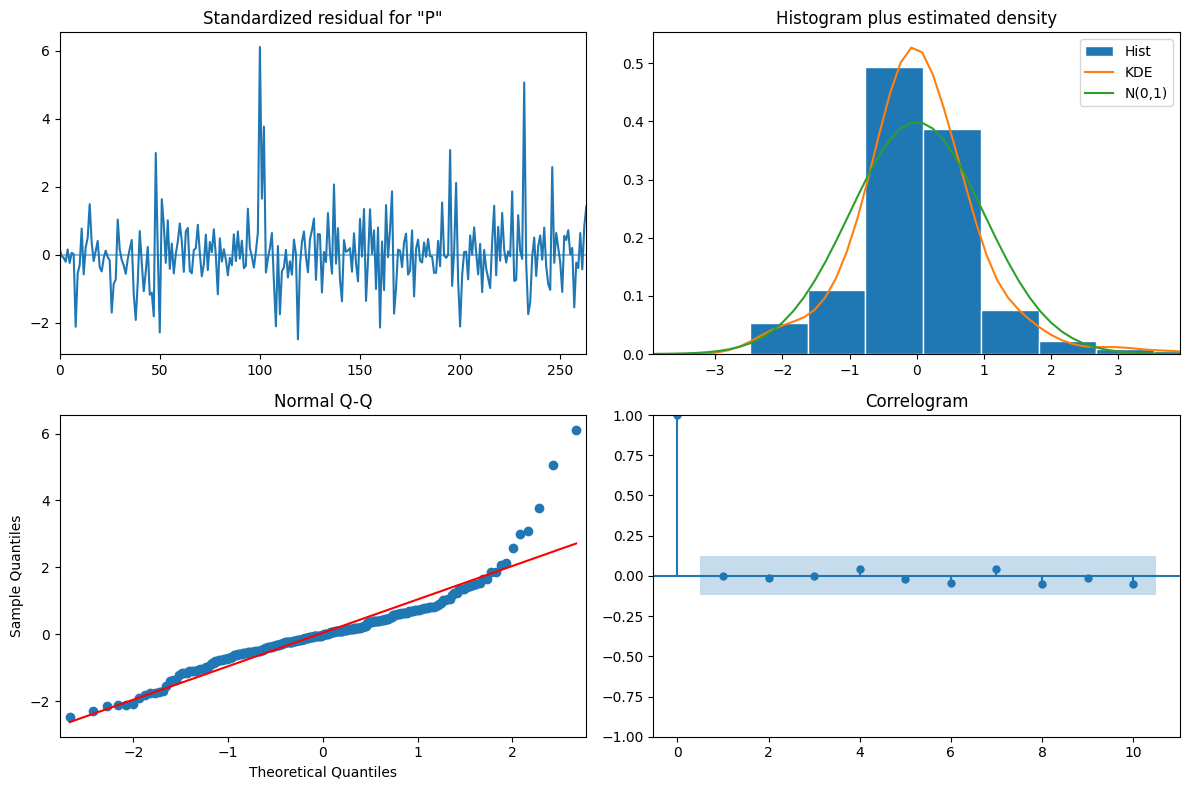

In [147]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

sarimax_model = SARIMAX(
    endog = y_train,
    exog = X_train,
    order=(0, 1, 0),
    # seasonal_order=(0,1,0,7)
    )
results = sarimax_model.fit(disp=False)
print(results.summary())

results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

The plot_diagnostics method above produces a 2x2 plot grid with the following plots (ordered clockwise from top left):
1. Standardized residuals over time
2. Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.
3. Normal Q-Q plot, with Normal reference line.
4. Correlogram

train a random forest regressor and xgb regressor and compare performance of different models
=> SARIMAX seems to perform the best.

In [148]:
from sklearn.metrics import mean_squared_error, r2_score

pred = results.get_prediction(start=X_train.shape[0],
                              end=X_train.shape[0] + X_test.shape[0] - 1,
                              exog=X_test)
pred_ci = pred.conf_int()
pred_mean = pred.predicted_mean
pred_mean.index = X_test.index
print(f'''SARIMAX model:
Mean Squared Error: {mean_squared_error(y_test, pred_mean)}
R2 Score: {r2_score(y_test, pred_mean)}
''')

# Train non-timeseries regression models
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(max_depth=2, random_state=5)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)
print(f'''RandomForestRegressor:
Mean Squared Error: {mean_squared_error(y_test, rf_pred)}
R2 Score: {r2_score(y_test, rf_pred)}
''')

from xgboost import XGBRegressor
xgb_reg = XGBRegressor(random_state=5)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
print(f'''RandomForestRegressor:
Mean Squared Error: {mean_squared_error(y_test, xgb_pred)}
R2 Score: {r2_score(y_test, xgb_pred)}
''')

SARIMAX model:
Mean Squared Error: 2377679.555917868
R2 Score: -0.23655252463332066

RandomForestRegressor:
Mean Squared Error: 5375807.867227817
R2 Score: -1.7957799332627338

RandomForestRegressor:
Mean Squared Error: 5151189.993134951
R2 Score: -1.678963603410379



# Create Bollinger Bands and compare it with the SARIMAX predictions to make trading decisions.

* if the predicted price is lower than the lower bound—> buy
* if the predicted price is higher than the upper bound—> sell
* if within the Bollinger band, hold.

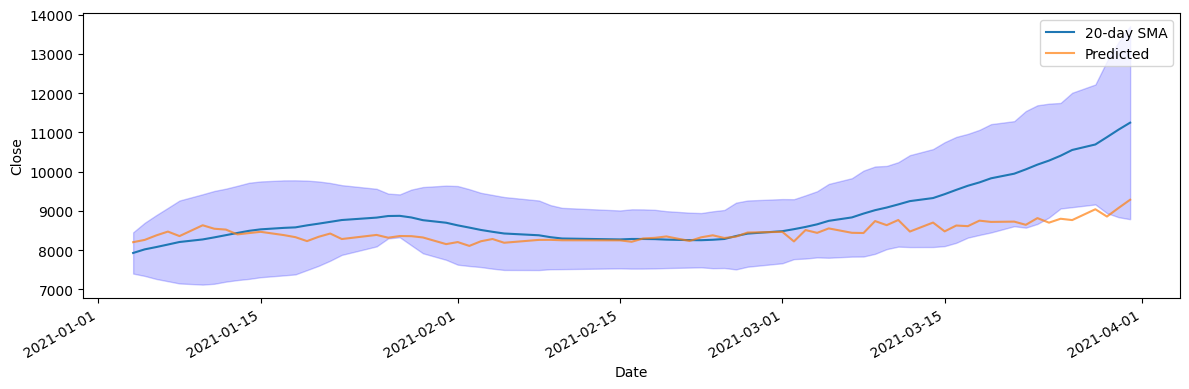

In [149]:
time_period = 20
rolling_mean = y.rolling(window=time_period).mean().loc[y_test.index]
rolling_std = y.rolling(window=time_period).std().loc[y_test.index]

ax = rolling_mean.plot(label='20-day SMA', figsize=(12, 4))
upper_band = (rolling_mean + (rolling_std * 2)).rename('Upper Band')
lower_band = (rolling_mean - (rolling_std * 2)).rename('Lower Band')

pred_mean.plot(ax=ax, label='Predicted', alpha=.7)

ax.fill_between(y_test.index,
                lower_band,
                upper_band,
                color='b', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()
plt.tight_layout()
plt.show()

Bollinger Band seem not useful since all predicted values are within the band.

Thus, use 20-day SMA to determine trading decision as follows:
* if the predicted price is lower than the SMA —> buy
* if the predicted price is higher than the SMA —> sell
* if within the Bollinger band, hold.

In [150]:
from datetime import timedelta
import numpy as np

daily_trading_dates = y_test.index

weekly_trading_dates = y_test.index[np.arange(5, len(y_test), 5)] # Trade every 5 trading days
# weekly_trading_dates = [y_test.index[0] + timedelta(weeks = num_week)
#                         for num_week in range(1, 13)]
# weekly_trading_dates = [weekly_trading_date if weekly_trading_date in y_test.index
#                         else weekly_trading_date + timedelta(days=1)
#                         for weekly_trading_date in weekly_trading_dates]

monthly_trading_dates = y_test.index[np.arange(20, len(y_test), 20)] # Trade every 20 trading days
# monthly_trading_dates = [(rolling_mean.index[0] + np.timedelta64(num_month, 'M')).replace(hour=0, minute=0, second=0, microsecond=0)
#                         for num_month in range(1, 3)]

In [151]:
results_df = pd.concat([y_test, rolling_mean.rename('20-day SMA'), pred_mean.rename('Predicted')], axis=1)
results_df

,Price,20-day SMA,Predicted
Date,,,
2021-01-04,8680.0,7928.5,8203.377173
2021-01-05,9130.0,8020.5,8261.420093
2021-01-06,9050.0,8079.5,8376.353208
2021-01-07,9140.0,8143.0,8472.987750
2021-01-08,9270.0,8208.0,8358.270767
...,...,...,...
2021-03-26,12200.0,10551.5,8766.155004
2021-03-28,12200.0,10691.5,9041.474611
2021-03-29,13550.0,10878.0,8856.108647


In [152]:
initial_balance = 0
initial_no_stock = 0
max_no_stock_to_trade = 1

results_dfs = {}
for interval, trading_dates in zip(['Daily', 'Weekly', 'Monthly'], [daily_trading_dates, weekly_trading_dates, monthly_trading_dates]):
    df = results_df.loc[trading_dates]
    df[f'Balance'] = initial_balance
    df[f'No. of Stock'] = initial_no_stock
    df[f'Trading Decision'] = 'Hold' # Default trading decision

    index_list = df.index
    last_index = index_list[-1]
    for i in range(len(df)):
        current_index = index_list[i]
        previous_index = index_list[max(0, i-1)]

        price = df.loc[current_index, 'Price'] 
        sma = df.loc[current_index, '20-day SMA']
        predicted = df.loc[current_index, 'Predicted']

        previous_balance = df.loc[previous_index, f'Balance']
        previous_no_stock = df.loc[previous_index, f'No. of Stock']         


        if (((sma > predicted) or (current_index == last_index))\
            and (previous_no_stock > 0)):
                df.loc[current_index, f'Trading Decision'] = 'Sell'
                
                # Sell all stocks at once
                if current_index == last_index:
                    df.loc[current_index, f'Balance'] = previous_balance + previous_no_stock * price
                    df.loc[current_index, f'No. of Stock'] = 0

                else:
                    no_stock_to_sell = min(max_no_stock_to_trade, previous_no_stock)
                    df.loc[current_index, f'Balance'] = previous_balance + price * no_stock_to_sell
                    df.loc[current_index, f'No. of Stock'] = previous_no_stock - no_stock_to_sell

        elif sma < predicted:
            df.loc[current_index, f'Trading Decision'] = 'Buy'

            df.loc[current_index, f'Balance'] = previous_balance - price * max_no_stock_to_trade
            df.loc[current_index, f'No. of Stock'] = previous_no_stock + max_no_stock_to_trade

        else:
            df.loc[current_index, f'Trading Decision'] = 'Hold'
            df.loc[current_index, f'Balance'] = previous_balance
            df.loc[current_index, f'No. of Stock'] = previous_no_stock

    results_dfs[interval] = df


capital_returns = 0
for interval, df in results_dfs.items():
    capital_return = df.iloc[-1]['Balance']
    capital_returns += capital_return
    print(f"{interval} capital return: {round(capital_return, 4)}")
print(f"Capital return in total: {round(capital_returns, 4)}")

Daily capital return: 970
Weekly capital return: 470
Monthly capital return: 0
Capital return in total: 1440


In [153]:
results_dfs['Daily'].tail(60)

,Price,20-day SMA,Predicted,Balance,No. of Stock,Trading Decision
Date,,,,,,
2021-01-14,9130.0,8492.5,8435.654946,-54270,6,Sell
2021-01-15,8850.0,8530.0,8466.952662,-45420,5,Sell
2021-01-17,8850.0,8567.5,8383.587518,-36570,4,Sell
2021-01-18,8440.0,8580.5,8330.814380,-28130,3,Sell
2021-01-19,8800.0,8631.5,8230.426114,-19330,2,Sell
2021-01-20,8690.0,8675.0,8340.291431,-10640,1,Sell
2021-01-21,8710.0,8721.0,8423.417296,-1930,0,Sell
2021-01-22,8720.0,8767.5,8283.446682,-1930,0,Hold
2021-01-25,8930.0,8829.0,8387.911687,-1930,0,Hold


In [154]:
results_dfs['Weekly'].tail(60)

,Price,20-day SMA,Predicted,Balance,No. of Stock,Trading Decision
Date,,,,,,
2021-01-10,9270.0,8273.0,8633.799651,-9270,1,Buy
2021-01-15,8850.0,8530.0,8466.952662,-420,0,Sell
2021-01-21,8710.0,8721.0,8423.417296,-420,0,Hold
2021-01-28,7850.0,8832.5,8356.475019,-420,0,Hold
2021-02-03,8070.0,8514.5,8226.761551,-420,0,Hold
2021-02-10,8180.0,8297.0,8251.708170,-420,0,Hold
2021-02-19,8460.0,8268.5,8349.407825,-8880,1,Buy
2021-02-25,9350.0,8359.5,8344.075397,470,0,Sell
2021-03-04,9400.0,8658.0,8440.357471,470,0,Hold


In [155]:
results_dfs['Monthly'].tail(60)

,Price,20-day SMA,Predicted,Balance,No. of Stock,Trading Decision
Date,,,,,,
2021-01-28,7850.0,8832.5,8356.475019,0,0,Hold
2021-02-25,9350.0,8359.5,8344.075397,0,0,Hold
2021-03-22,11550.0,10057.5,8645.368156,0,0,Hold


In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
corr_df = pd.concat([
    y_train_1,
    X_train_1],
    axis=1).corr()
sns.heatmap(corr_df)
plt.xticks(rotation = -45)
plt.tight_layout()

NameError: name 'y_train_1' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
# Downsampling and aggregating by taking the mean of each hour
collapsed_data = df.resample('H').mean()

# Downsampling and aggregating by taking the sum of each day
collapsed_data = df.resample('D').sum()

# Downsampling and aggregating by taking the maximum value of each month
collapsed_data = df.resample('M').max()

### <b>3. Add features and plot data</b>

- 3-1. add weekly/monthly/quarterly rolling average (or simple moving average; SMA), EMA (exponential MA)

One advantage of the EMA over SMA is that EMA is more responsive to price changes, which makes it useful for short-term trading.
    SMA assigns equal weights to all historical data points,
    EMA applies higher weights to recent prices

In [ ]:
train_df_1 = add_moving_average(train_df_1)
test_df_1 = add_moving_average(test_df_1)

- 3-2. Get datetime values from index and add them as new features

In [ ]:
train_df_1 = add_datetime_features(train_df_1, year=False, month=True, day=True, weekday=True)
test_df_1 = add_datetime_features(test_df_1, year=False, month=True, day=True, weekday=True)

- 3-3. STL decomposition (Seasonal and Trend decomposition using Loess (locally estimated scatterplot smoothing?))

Plot seasonal componets of train_df_1:


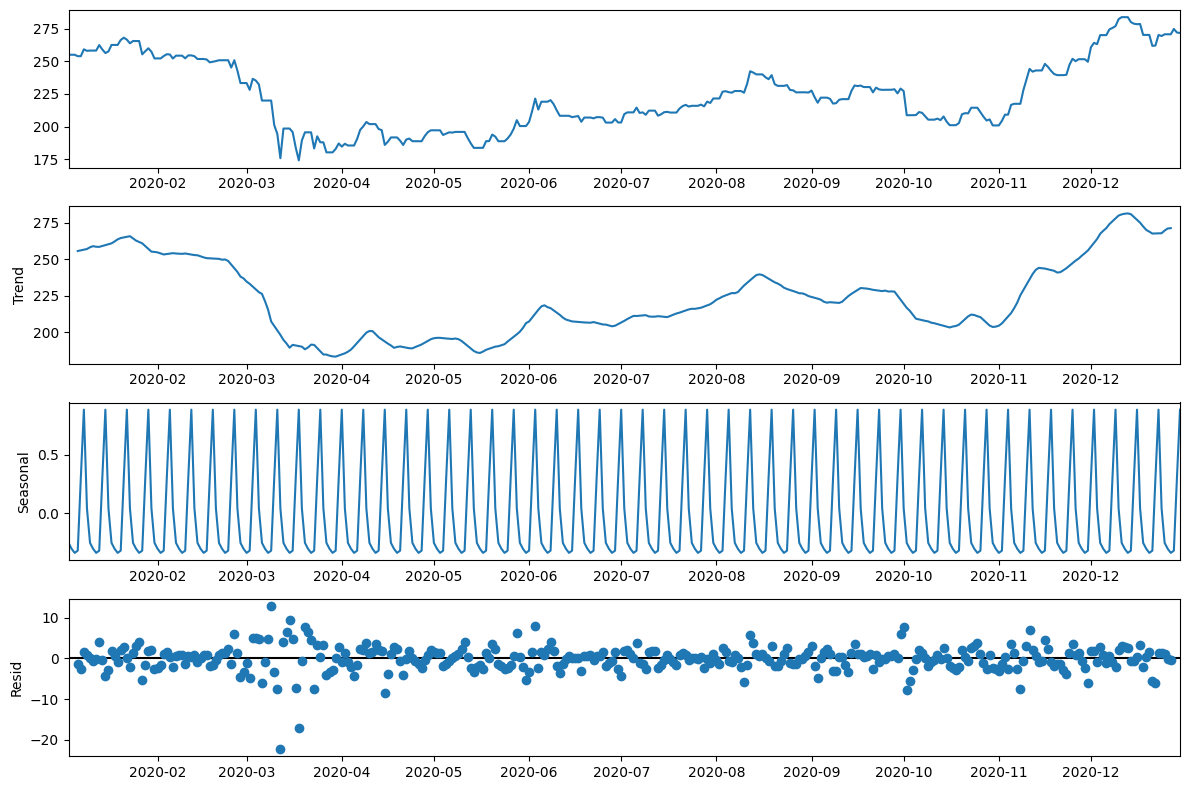

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

print('Plot seasonal componets of train_df_1:')
train_df_1 = add_seasonal_components(df=train_df_1, frequency='D', column='Close', add_to_df=True, plot=True)
test_df_1 = add_seasonal_components(df=test_df_1, frequency='D', column='Close', add_to_df=True, plot=False)

the original data (first plot) is very similar to the Trend data (second plot), indicating seasonality in the timeseries data is not significant.

- 3-4. PACF: the autocorrelation function

The PACF is an alternative to the ACF. Rather than giving the autocorrelations, it gives you the partial autocorrelation. This autocorrelation is called partial, because with each step back in the past, only additional autocorrelation is listed. This is different from the ACF, as the ACF contains duplicate correlations when variability can be explained by multiple points in time.

you will see a blue area in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

The autocorrelation analysis helps in detecting hidden patterns and seasonality and in checking for randomness. It is especially important when you intend to use an ARIMA model for forecasting because the autocorrelation analysis helps to identify the AR and MA parameters for the ARIMA model.

In [ ]:
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(train_df_1['Close'])

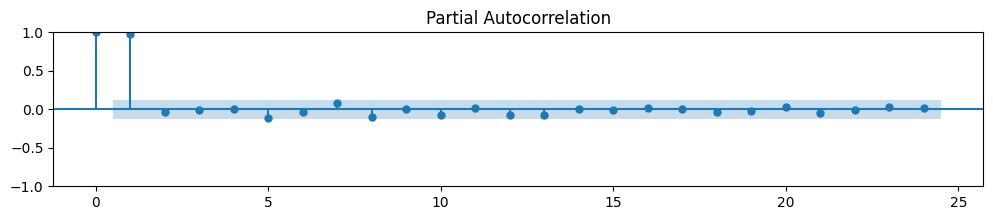

In [ ]:
rcParams['figure.figsize'] = 12, 2
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_df_1['Close'], method='ywm');

There's little autocorrelation after the first two dates, meaning only the next date would be highly correlated with each date in the timeseries data, which makes sense for stock market price data.

### <b>4. normalize scales</b>

* use the StandardScaler, rather than the MinMaxScaler,
The reason is that stock prices are ever-changing, and there are no true min or max values.
It doesn’t make sense to use the MinMaxScaler, although this choice probably won’t lead to
disastrous results at the end of the day;

In [ ]:
normalized_train_df_1, normalized_test_df_1 = normalize_scale(train_df_1, test_df_1, method='standard', exclude_column='Close')
normalized_train_df_1.describe()

,Close,Open,High,Low,Vol.,Change %,Weekly SMA,Monthly SMA,Quarterly SMA,Weekly EMA,Monthly EMA,Quarterly EMA,Month,Day,Weekday,Trend,Seasonal,Residual
count,250.000000,2.500000e+02,2.500000e+02,2.500000e+02,250.000000,2.500000e+02,2.440000e+02,2.210000e+02,1.600000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.460000e+02,2.500000e+02,2.460000e+02
mean,224.216280,-2.842171e-17,1.122658e-15,1.705303e-16,0.000000,-2.131628e-17,1.747236e-16,1.253899e-15,-1.554312e-16,4.973799e-16,-5.115908e-16,2.273737e-15,1.136868e-16,9.903189e-17,3.108624e-17,-5.487932e-16,-2.664535e-18,7.220963e-18
std,26.778554,1.002006e+00,1.002006e+00,1.002006e+00,1.002006,1.002006e+00,1.002056e+00,1.002270e+00,1.003140e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002039e+00,1.002006e+00,1.002039e+00
min,174.270000,-1.842935e+00,-1.686389e+00,-1.822672e+00,-1.522260,-4.147471e+00,-1.481173e+00,-1.466743e+00,-1.646413e+00,-1.484374e+00,-1.442682e+00,-1.158744e+00,-1.625037e+00,-1.729325e+00,-1.422742e+00,-1.551809e+00,-1.036980e+00,-6.814241e+00
25%,203.790000,-7.644503e-01,-7.795605e-01,-7.446363e-01,-0.687759,-4.580563e-01,-6.786079e-01,-7.548754e-01,-8.062869e-01,-6.950752e-01,-8.445118e-01,-8.044405e-01,-7.532358e-01,-8.094714e-01,-7.142049e-01,-7.319138e-01,-8.834194e-01,-4.569990e-01
50%,220.145000,-1.568639e-01,-1.728705e-01,-1.642128e-01,-0.208069,-5.499641e-03,-1.445320e-01,-6.522494e-02,8.375928e-02,-1.299714e-01,-1.258661e-01,-3.393298e-01,1.185649e-01,-4.599269e-03,-5.668293e-03,-1.561760e-01,-2.016100e-01,8.697638e-02
75%,247.825000,8.930813e-01,8.577104e-01,8.459921e-01,0.388021,5.418784e-01,7.749575e-01,4.754287e-01,5.325338e-01,8.357387e-01,8.336402e-01,6.211810e-01,9.903656e-01,8.002728e-01,7.028683e-01,7.779803e-01,3.921471e-01,5.177492e-01
max,283.730000,2.288127e+00,2.295581e+00,2.183162e+00,4.603962,5.537242e+00,2.198452e+00,2.341664e+00,2.141993e+00,2.093425e+00,1.824321e+00,2.056014e+00,1.571566e+00,1.720127e+00,1.411405e+00,2.225260e+00,1.740114e+00,2.432579e+00


### <b>5. perform EDA, assess feature importance (feature selection)</b>

check feature importance and only use relevant ones
- run_chi_tests (chi-square test of independce) (Happy Customers, Term Deposit Marketing)
- correlation
- plot_histograms (Term Deposit Marketing)
- get_top_features (EDA and feature selection) (milestone 2)

Distribution of target "Close" and dependent variables:


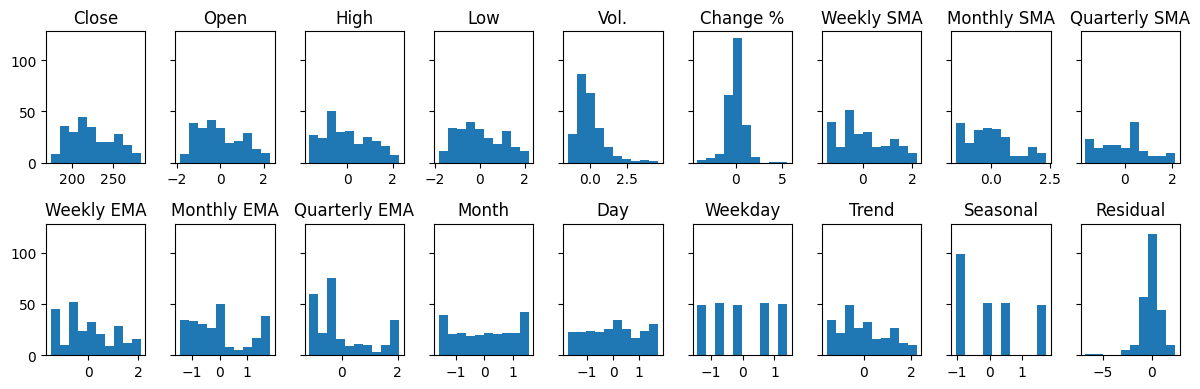

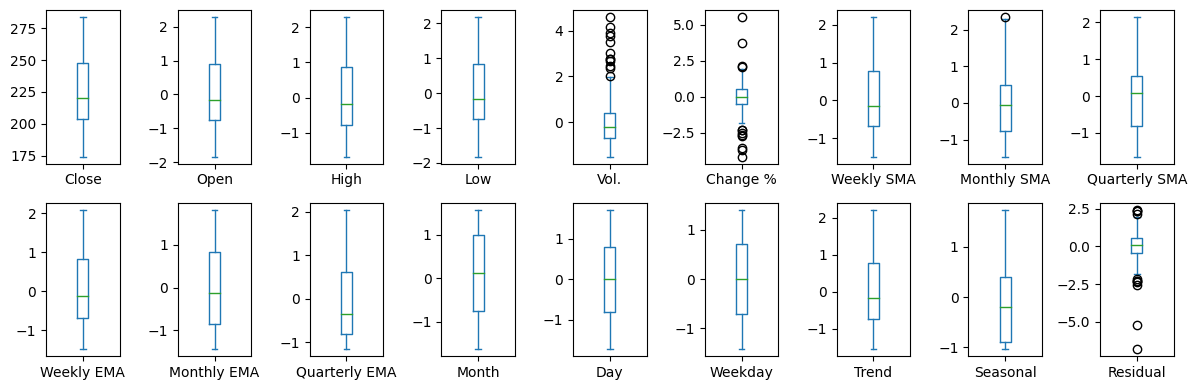

In [ ]:
plot_histograms(data=normalized_train_df_1,
                target='Close', target_figsize=(2,2),
                dependent_layout=(2,9), dependent_figsize=(12, 4),
                include_boxplots=True)

In [ ]:
results_dfs = run_chi_tests(normalized_train_df_1, target='Close', significance_level=0.05,
                            plot_title=None, plot_title_y=None,
                            plot_row=3, plot_col=6, figsize=None, plot=False,
                            rotate_x_label_col=[], rotate_angle=None,
                            h_pad=3, print_result_df=False,
                            independence_test=True,
                            goodness_of_fit_test=False)

print('''
If the null hypothesis is not rejected at the significance level of 0.05,
the Variable and the target (i.e. Close) are independent of each other.
''')
results_dfs[0]


If the null hypothesis is not rejected at the significance level of 0.05,
the Variable and the target (i.e. Close) are independent of each other.



,Independent Variable,Chi-square,P-value,Reject Null Hypothesis at alpha=0.05?
Variable,,,,
Weekly EMA,NaN,61250.000000,0.241223,No
Monthly EMA,NaN,61250.000000,0.241223,No
Quarterly EMA,NaN,61250.000000,0.241223,No
Vol.,NaN,60250.000000,0.257685,No
High,NaN,59750.000000,0.266231,No
Low,NaN,59750.000000,0.266231,No
Trend,NaN,59286.000000,0.241247,No
Residual,NaN,59286.000000,0.241247,No
Weekly SMA,NaN,58072.000000,0.245398,No


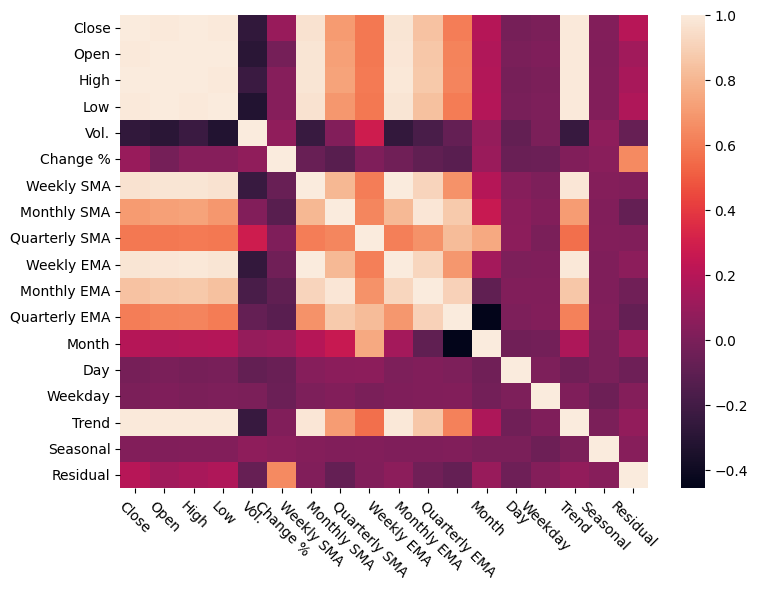

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(normalized_train_df_1.corr())
plt.xticks(rotation = -45)
plt.tight_layout()

In [ ]:
corr_df = normalized_train_df_1.corr()
print('Features with correlation equal to or lower than 0.7:')
print(corr_df[['Close']][corr_df.loc['Close'] <= 0.7])
print('\nFeatures with correlation higher than 0.7:')
print(corr_df[['Close']][corr_df.loc['Close'] > 0.7])

cols_to_keep = list(corr_df['Close'][corr_df.loc['Close'] > 0.7].index)
print('Features to use for training a prediction model:')
cols_to_keep

Features with correlation equal to or lower than 0.7:
                  Close
Vol.          -0.265379
Change %       0.099591
Quarterly SMA  0.589865
Quarterly EMA  0.603654
Month          0.194907
Day           -0.016961
Weekday        0.003600
Seasonal       0.025313
Residual       0.201241

Features with correlation higher than 0.7:
                Close
Close        1.000000
Open         0.989138
High         0.995150
Low          0.993580
Weekly SMA   0.965238
Monthly SMA  0.701028
Weekly EMA   0.976251
Monthly EMA  0.845845
Trend        0.992077
Features to use for training a prediction model:


['Close',
 'Open',
 'High',
 'Low',
 'Weekly SMA',
 'Monthly SMA',
 'Weekly EMA',
 'Monthly EMA',
 'Trend']

In [ ]:
# import matplotlib.pyplot as plt

# train_df_1['Quarterly EMA'].plot(label='Quarterly EMA')
# train_df_1['Quarterly SMA'].plot(label='Quarterly SMA')
# plt.legend();

In [ ]:
# from statsmodels.tsa.api import SimpleExpSmoothing

# es = SimpleExpSmoothing(train_df_1.Close.values)
# es.fit(smoothing_level=0.1)

# plt.plot(train_df_1.Close.values, label='Close')
# plt.plot(es.predict(es.params, start=0, end=None), label='Predicted')
# plt.legend();

### <b>5. Train a model</b>

* for nan values, you could consider discarding them if you have enough data.
Or you could plot the data to see how the nan values can be filled (e.g. average, ffill, bfill, etc.). It could be hard to figure this out, so it such cases, could just drop the nan values becausing imputing can bring bias that might not be helpful to the model/predictions.

if the predicted price is lower than the lowerbound =>  buy
if the predicted price is within the Bollinger band => hold
if the predicted price is higher than the upperbound— => sell

1 train a model and predict on a daily, weekly and monthly basis.

2 calculate threshold/uncertainty (of the prediction) (+ bollinger band of the observed data?)<br>
Typical values used:<br>
Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)<br>
Medium term: 20 day moving average, bands at 2 standard deviations.<br>
Long term: 50 day moving average, bands at 2.5 standard deviations.<br>
                                                       
3 decide to buy/hold/sell based on the threshold

4 store the value/profit if I had traded based on the decision. (also need to define how many money/stock I already have.)

SARIMAX is a powerful tool for modeling and forecasting time series data, especially when there are known seasonal patterns and the influence of exogenous variables needs to be considered.

In a SARIMAX model, the time series is assumed to have both non-seasonal and seasonal components. The non-seasonal component is captured by the ARIMA model, while the seasonal component is captured by the seasonal ARIMA (SARIMA) model. The inclusion of exogenous variables allows for the incorporation of additional factors that may influence the time series.

The SARIMAX model is typically denoted as SARIMAX(p, d, q)(P, D, Q, s), where:

p, d, and q are the orders of the non-seasonal AR, differencing, and MA components, respectively.
P, D, Q, and s are the orders of the seasonal AR, differencing, MA components, and the seasonal period, respectively.
Exogenous variables can be included in the model by specifying them separately.

The SARIMAX model assumes that the time series is stationary after differencing. It models the relationship between the observations and the lags of the observations (autoregressive terms), the differences between observations (differencing terms), and the errors (moving average terms), both in the non-seasonal and seasonal components.

p is the number of autoregressive terms
d is the number of non-seasonal differences needed for stationarity
q is the number of lagged forecast errors in the prediction equation

ARIMA. it just takes the past values of the stock market.

=> move on to SARIMA. S stands for seasonality.

=> SARIMAX - also takes into account external features (i.e, other features)
SARIMAX stands for ‘Seasonal Auto Regressive Integrated Moving Average with eXogenus factors’

=> primarily they are used for understanding the patterns or features of the time series data but we can use them for predictions.

facebook's PROPHET. easy to understand. conceptually similar to SARIMAX.

Uber's timeseries prediction model.


https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b

20:36:39 - cmdstanpy - INFO - Chain [1] start processing
20:36:39 - cmdstanpy - INFO - Chain [1] done processing
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


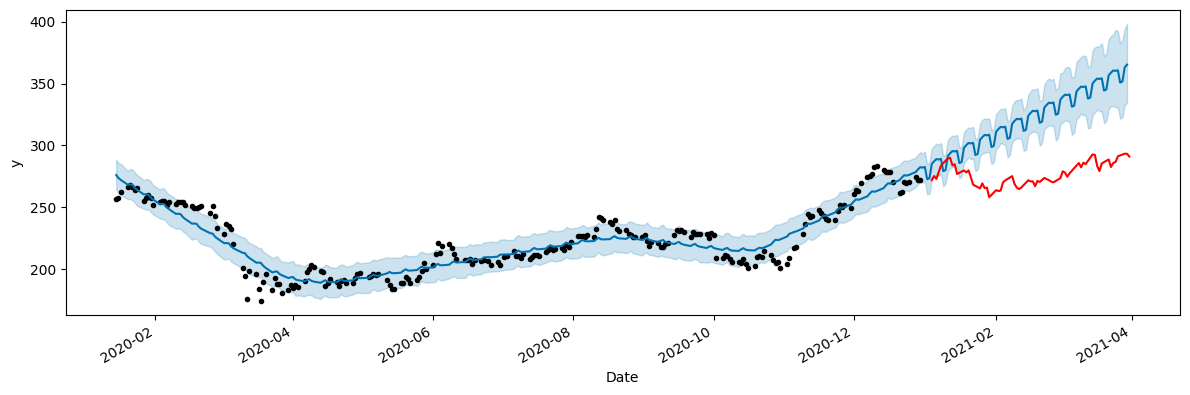

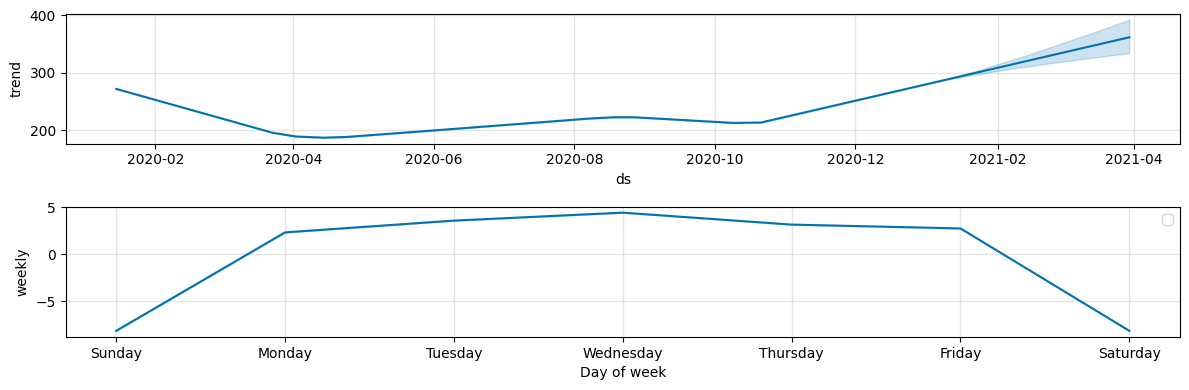

In [ ]:
from prophet import Prophet
m = Prophet()
m.fit(pd.concat([X_train, y_train], axis=1).reset_index().rename(columns={'Date': 'ds', 'Price': 'y'}))

# Forecast for the next 3 months
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
# print(forecast.tail())

m.plot(forecast, figsize=(12, 4))
y_test.plot(label='Price', color='red')
m.plot_components(forecast, figsize=(12, 4))
plt.legend();

3. set evaluation metrics
(e.g., Since stock prices prediction is essentially a regression problem,
 the RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %)
 will be our current model evaluation metrics. Both are useful measures of forecast accuracy. )


4. build a prediction model
* When predicting short-term stock prices, it is generally better to focus on more recent data rather than using the data from the entire year. However, it's important to strike a balance between using recent data and having enough historical context. It's recommended to experiment with different time periods and evaluate the performance of your predictions to find the optimal balance.

* LSTM, short for Long Short-term Memory, is an extremely powerful algorithm for time series.
    It can capture historical trend patterns, and predict future values with high accuracy. 
https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233
https://www.projectpro.io/article/stock-price-prediction-using-machine-learning-project/571
=> can be difficult/time-consuming to understand. can be tried out after trying simpler models.

* Seasonal autoregressive integrated moving-average with exogenous regressors (SARIMAX)
The most complex variant is the SARIMAX model. It regroups AR, MA, differencing, and seasonal effects.
On top of that, it adds the X: external variables. If you have any variables that could help your model to improve,
you could add them with SARIMAX.

* exponential smoothing
from statsmodels.tsa.api import SimpleExpSmoothing
es = SimpleExpSmoothing(co2_data.co2.values)
es.fit(smoothing_level=0.01)
plt.plot(co2_data.co2.values)
plt.plot(es.predict(es.params, start=0, end=None))
plt.show()
=> takes in only 1 column

* Reinforcement learning
https://www.analyticsvidhya.com/blog/2020/10/reinforcement-learning-stock-price-prediction/


5. evaluate model performance
=> create bollinger bands using the prediced price and recommend buy, hold, or sell decisions?


6. based on the final model prediction, recommend BUY, HOLD, SELL decisions for each stock.
(Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.)


7. evaluate on the basis of capital returns (based on the trading decisions).
how to quantify or calculate the returns when we don't know how many stocks we had and when we bought them?


8. use bollinger bands to measure the system/model's effectiveness??

Candlestick charts are used by traders to determine possible price movement based on past patterns. Candlesticks are useful when trading as they show four price points (open, close, high, and low) throughout the period of time the trader specifies.

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(data=[
#     go.Candlestick(
#     x=train_df_1.index,
#     open=train_df_1['Open'],
#     high=train_df_1['High'],
#     low=train_df_1['Low'],
#     close=train_df_1['Close']
#     )
#     ])

# # fig.update_layout(
# #     margin=dict(l=30, r=30, t=10, b=10),
# #     # paper_bgcolor='LightSteelBlue',
# # )

# fig.update_layout(
#     title=f'{stock_name_1}: Daily OHLC', 
#     yaxis_title='Price (USD)',
#     width=900,
#     height=600)

# fig.show()

In [ ]:
# # Candlestick Chart and Volume Separately
# # Source: https://medium.com/codex/creating-candlestick-charts-using-python-plotly-8081c4820351

# from plotly.subplots import make_subplots

# # figure with secondary y-axis
# fig = make_subplots(specs=[[{'secondary_y': True}]])

# # candlestick
# fig.add_trace(
#     go.Candlestick(
#         x=train_df_1.index,
#         open=train_df_1.Open,
#         high=train_df_1.High,
#         low=train_df_1.Low,
#         close=train_df_1.Close,
#         showlegend=False),
#     row=1,
#     col=1,
#     secondary_y=True
# )

# # volume
# fig.add_trace(
#     go.Bar(x=train_df_1.index,
#            y=train_df_1['Vol.'],
#            showlegend=False,
#            marker={
#                'color': 'grey',
#            }),
#     secondary_y=False,
# )

# fig.update_layout(title=f'{stock_name_1}: Daily OHLCV',
#                   yaxis_title='Price (USD)',
#                   width=900,
#                   height=600)

# fig.show()

if the target is short-term decision, 

bullish patterns -> price likely to rise => buy
bearish patterns -> price likely to fall => sell

If a candlestick pattern doesn’t indicate a change in market direction, it is what is known as a continuation pattern. These can help traders to identify a period of rest in the market, when there is market indecision or neutral price movement. => hold

https://neptune.ai/blog/predicting-stock-prices-using-machine-learning

https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning

2. Create Bollinger Bands for 2020 for each company

Typical values used:

Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)

Medium term: 20 day moving average, bands at 2 standard deviations.

Long term: 50 day moving average, bands at 2.5 standard deviations.

From Semih:

Typically bollinger bands are used to make buy and sell decisions if the predicted price is lower than the lowerbound—> buy if the predicted price is higher than the upperbound—> sell

My interpretation is (the way I would approach) we can use bollinger bands to label the data. Afterwards a classifier or a recommendation system could be developed to predict buy and sell decisions. Based on the recommended actions a loss or profit could be calculated. I don’t think there is only one approach but this is how I would approach it.